<a href="https://colab.research.google.com/github/frankwillard/NBA-Web-Scraper-And-ANN/blob/main/TensorFlow_NBA_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow NBA Champion Neural Network

Inspired by the TensorFlow tutorial on working with Imbalanced Data

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Importing the libraries

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [42]:
tf.__version__

'2.8.0'

## Part 1 - Data Preprocessing

### Importing and viewing the dataset

In [43]:
dataset = pd.read_csv('nba_team_advanced_data.csv')
dataset.head()

,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,DRB%,DFT/FGA,Arena,Attend.,Playoffs,W/L%,Losing_season,Champion,won_last,won_last_3
0,1990.0,Atlanta Hawks,28.6,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,...,65.5,0.254,Omni Coliseum,573711.0,N,0.500000,N,N,N,N
1,1990.0,Boston Celtics,30.2,52.0,30.0,51.0,31.0,3.99,-0.76,3.23,...,72.1,0.223,Boston Garden,611537.0,Y,0.634146,N,N,N,N
2,1990.0,Charlotte Hornets,25.6,19.0,63.0,21.0,61.0,-7.82,0.81,-7.00,...,67.5,0.269,Charlotte Coliseum,979941.0,N,0.231707,Y,N,N,N
3,1990.0,Chicago Bulls,26.1,55.0,27.0,50.0,32.0,3.26,-0.51,2.74,...,68.1,0.262,Chicago Stadium,752564.0,Y,0.670732,N,N,N,N
4,1990.0,Cleveland Cavaliers,26.1,42.0,40.0,40.0,42.0,-0.30,-0.31,-0.62,...,67.7,0.202,Coliseum at Richfield,695710.0,Y,0.512195,N,N,N,N


In [44]:
dataset = dataset[dataset["Playoffs"] == "Y"]

In [45]:
dataset = dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

In [46]:
dataset.columns

Index(['Year', 'Team', 'Age', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg',
       'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA',
       'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'W/L%', 'Champion', 'won_last',
       'won_last_3'],
      dtype='object')

In [47]:
#Drop Year, Champion, Team
X = dataset.iloc[:, ~ dataset.columns.isin(['Year', 'Champion', 'Team'])]
y = dataset.loc[:, dataset.columns == 'Champion'].values
y = np.array([0 if val == "N" else 1 for val in y])

### Identifying Class Imbalance

In [48]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 512
    Positive: 32 (6.25% of total)



### Encode Categorical Values

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#3 because want to one hot encode State variable
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['won_last', 'won_last_3'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Splitting the dataset into the Training set and Test set

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y,train_size=0.75, test_size=0.25, random_state=7)

### Feature Scaling

In [52]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
#X_test = sc.transform(X_test)

### Checking Dimensions of Inputs

In [53]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)

Training labels shape: (384,)
Validation labels shape: (128,)
Training features shape: (384, 24)
Validation features shape: (128, 24)


## Part 2 - Building the Baseline ANN

### Setting Model Hyperparameters

In [54]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [55]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
input_shape = X_train.shape[-1]

In [56]:
#!pip install tensorflow_addons
#import tensorflow_addons as tfa
#fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.0001, gamma=2.0)

In [57]:
tf.random.set_seed(0)

### Building the Model

In [58]:
def create_model(input_shape = input_shape, metrics=METRICS, optimizer= opt, loss_function = loss, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(input_shape = (input_shape, ), units=200, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid', bias_initializer = output_bias))
  ann.compile(optimizer = opt, loss = loss_function, metrics=metrics)
  return ann

### Further Defining Model Hyperparameters

In [59]:
EPOCHS = 200
BATCH_SIZE = 16
val_data = (X_val, y_val)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_prc", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

### Defining an Initial Bias (Based on the Log Odds of the Response Variable)

In [60]:
initial_bias = np.log([pos/neg])

### Summarizing the Model

In [61]:
model = create_model(output_bias = initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               5000      
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

### Saving the Initial Weights

In [62]:
import tempfile
import os

In [63]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Determining the Effectiveness of Log Odds Bias

In [64]:
model = create_model()
model.load_weights(initial_weights)
#KEY DIFFERENCE- 0 BIAS
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

In [65]:
model = create_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

#### Plotting the Losses

In [66]:
import matplotlib.pyplot as plt

In [67]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [68]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

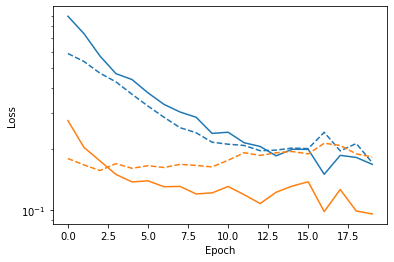

In [69]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

It is clear from the visualization that the initial bias reduces the loss, such that we include it in our baseline model

### Running the Baseline Model

In [70]:
model = create_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data)

Epoch 1/200
24/24 [==============================] - 4s 60ms/step - loss: 0.2783 - tp: 9.0000 - fp: 19.0000 - tn: 461.0000 - fn: 23.0000 - accuracy: 0.9180 - precision: 0.3214 - recall: 0.2812 - auc: 0.7701 - prc: 0.2257 - val_loss: 0.1805 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 121.0000 - val_fn: 7.0000 - val_accuracy: 0.9453 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8011 - val_prc: 0.3432
Epoch 2/200
24/24 [==============================] - 0s 6ms/step - loss: 0.2157 - tp: 5.0000 - fp: 10.0000 - tn: 349.0000 - fn: 20.0000 - accuracy: 0.9219 - precision: 0.3333 - recall: 0.2000 - auc: 0.8487 - prc: 0.2325 - val_loss: 0.1668 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 120.0000 - val_fn: 6.0000 - val_accuracy: 0.9453 - val_precision: 0.5000 - val_recall: 0.1429 - val_auc: 0.8760 - val_prc: 0.3557
Epoch 3/200
24/24 [==============================] - 0s 6ms/step - loss: 0.1632 - tp: 8.0000 - fp: 6.0000 - tn: 353.0000 - fn: 17.0000 - accuracy: 0.9401 - p

### Plotting the Metrics of Baseline Model

In [71]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

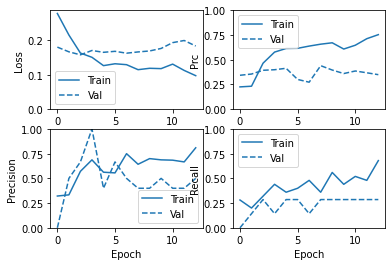

In [72]:
plot_metrics(baseline_history)

In [73]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_val, batch_size=BATCH_SIZE)

In [74]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [75]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Champions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Champions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Non Champions Missed (False Negatives): ', cm[1][0])
  print('Non Champions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.16649213433265686
tp :  2.0
fp :  3.0
tn :  118.0
fn :  5.0
accuracy :  0.9375
precision :  0.4000000059604645
recall :  0.2857142984867096
auc :  0.8996458053588867
prc :  0.44033730030059814

Legitimate Champions Detected (True Negatives):  118
Legitimate Champions Incorrectly Detected (False Positives):  3
Non Champions Missed (False Negatives):  5
Non Champions Detected (True Positives):  2
Total Fraudulent Transactions:  7


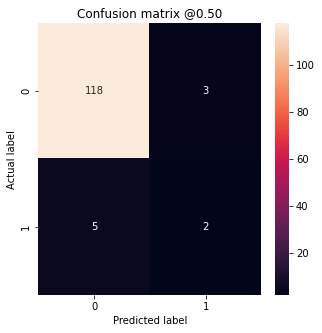

In [76]:
baseline_results = model.evaluate(X_val, y_val,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_baseline)

In [77]:
import sklearn

In [78]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([50,100.5])
  plt.grid(True)
  ax = plt.gca()
  #ax.set_aspect('equal')

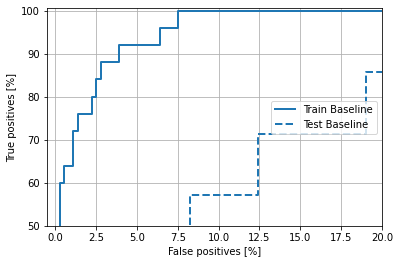

In [79]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='center right');

In [80]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

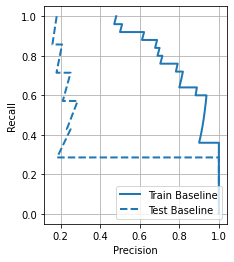

In [81]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Part 3- Weighted Model

### Introducing Class Weights

In [82]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.00


### Running the Weighted Model

In [83]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data,
    # The class weights go here
    class_weight=class_weight)

Epoch 1/200
24/24 [==============================] - 3s 50ms/step - loss: 0.7189 - tp: 20.0000 - fp: 70.0000 - tn: 410.0000 - fn: 12.0000 - accuracy: 0.8398 - precision: 0.2222 - recall: 0.6250 - auc: 0.8146 - prc: 0.2126 - val_loss: 0.1904 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 119.0000 - val_fn: 5.0000 - val_accuracy: 0.9453 - val_precision: 0.5000 - val_recall: 0.2857 - val_auc: 0.8784 - val_prc: 0.3033
Epoch 2/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6227 - tp: 16.0000 - fp: 71.0000 - tn: 288.0000 - fn: 9.0000 - accuracy: 0.7917 - precision: 0.1839 - recall: 0.6400 - auc: 0.8415 - prc: 0.2562 - val_loss: 0.2253 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 118.0000 - val_fn: 5.0000 - val_accuracy: 0.9375 - val_precision: 0.4000 - val_recall: 0.2857 - val_auc: 0.8471 - val_prc: 0.2240
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 0.3745 - tp: 23.0000 - fp: 72.0000 - tn: 287.0000 - fn: 2.0000 - accuracy: 0.8073 - precision: 0.24

### Plotting the Metrics of Weighted Model

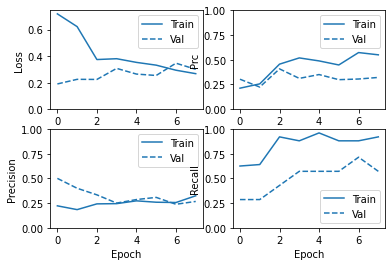

In [84]:
plot_metrics(weighted_history)

In [85]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.22447741031646729
tp :  3.0
fp :  6.0
tn :  115.0
fn :  4.0
accuracy :  0.921875
precision :  0.3333333432674408
recall :  0.4285714328289032
auc :  0.8760330677032471
prc :  0.4078656733036041

Legitimate Champions Detected (True Negatives):  115
Legitimate Champions Incorrectly Detected (False Positives):  6
Non Champions Missed (False Negatives):  4
Non Champions Detected (True Positives):  3
Total Fraudulent Transactions:  7


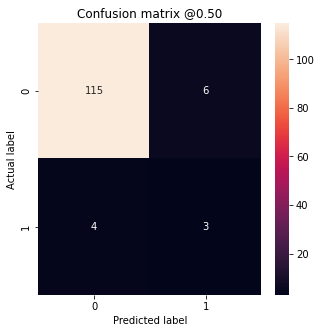

In [86]:
weighted_results = weighted_model.evaluate(X_val, y_val,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_weighted)

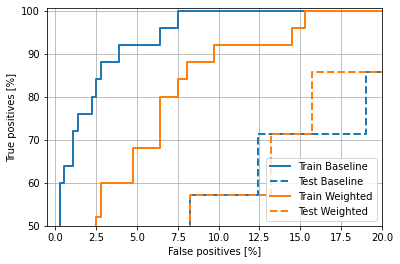

In [87]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

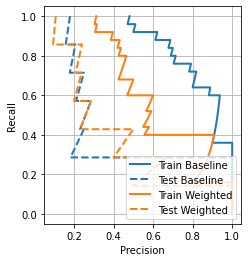

In [88]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Part 4- Oversampled Model

### Determining positive and negative labels

In [89]:
bool_train_labels = y_train != 0

In [90]:
pos_X_train = X_train[bool_train_labels]
neg_X_train = X_train[~bool_train_labels]

pos_y_train = y_train[bool_train_labels]
neg_y_train = y_train[~bool_train_labels]

### Resampling positive samples to even out representation

In [91]:
ids = np.arange(len(pos_X_train))
choices = np.random.choice(ids, len(neg_X_train))

res_pos_X_train = pos_X_train[choices]
res_pos_y_train = pos_y_train[choices]

res_pos_X_train.shape

(359, 24)

### Defining dataset with resampled data and shuffling it

In [92]:
resampled_features = np.concatenate([res_pos_X_train, neg_X_train], axis=0)
resampled_labels = np.concatenate([res_pos_y_train, neg_y_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(718, 24)

### Building the Resampled Model

In [93]:
resampled_model = create_model()
resampled_model.load_weights(initial_weights)

In [94]:
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [95]:
val_ds = tf.data.Dataset.from_tensor_slices(val_data).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

### Redefining epoch (number of batches to see each negative sample)

In [96]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

### Running the Resampled Model

In [97]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[earlystopping],
    validation_data=val_ds)

Epoch 1/200
60/60 [==============================] - 4s 21ms/step - loss: 0.4733 - tp: 305.0000 - fp: 70.0000 - tn: 410.0000 - fn: 61.0000 - accuracy: 0.8452 - precision: 0.8133 - recall: 0.8333 - auc: 0.9033 - prc: 0.8439 - val_loss: 0.4778 - val_tp: 5.0000 - val_fp: 22.0000 - val_tn: 99.0000 - val_fn: 2.0000 - val_accuracy: 0.8125 - val_precision: 0.1852 - val_recall: 0.7143 - val_auc: 0.8784 - val_prc: 0.4349
Epoch 2/200
60/60 [==============================] - 0s 4ms/step - loss: 0.3039 - tp: 327.0000 - fp: 58.0000 - tn: 301.0000 - fn: 32.0000 - accuracy: 0.8747 - precision: 0.8494 - recall: 0.9109 - auc: 0.9417 - prc: 0.9259 - val_loss: 0.4088 - val_tp: 5.0000 - val_fp: 17.0000 - val_tn: 104.0000 - val_fn: 2.0000 - val_accuracy: 0.8516 - val_precision: 0.2273 - val_recall: 0.7143 - val_auc: 0.8961 - val_prc: 0.3281
Epoch 3/200
60/60 [==============================] - 0s 4ms/step - loss: 0.3021 - tp: 321.0000 - fp: 52.0000 - tn: 307.0000 - fn: 38.0000 - accuracy: 0.8747 - precision

### Plotting Metrics of Resampled Model

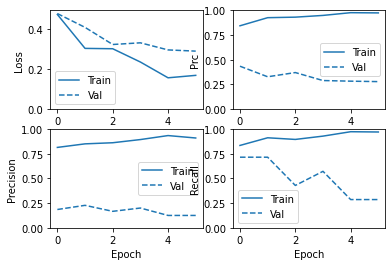

In [98]:
plot_metrics(resampled_history)

### Decreasing steps_per_epoch to reduce overfitting (let early stopping prevent it)

In [99]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,    
    steps_per_epoch=20,# These are not real epochs
    epochs=10*EPOCHS,
    callbacks=[earlystopping],
    validation_data=(val_ds))

Epoch 1/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.2573 - tp: 334.0000 - fp: 41.0000 - tn: 318.0000 - fn: 25.0000 - accuracy: 0.9081 - precision: 0.8907 - recall: 0.9304 - auc: 0.9581 - prc: 0.9273 - val_loss: 0.4651 - val_tp: 6.0000 - val_fp: 19.0000 - val_tn: 102.0000 - val_fn: 1.0000 - val_accuracy: 0.8438 - val_precision: 0.2400 - val_recall: 0.8571 - val_auc: 0.8949 - val_prc: 0.3211
Epoch 2/2000
20/20 [==============================] - 0s 6ms/step - loss: 0.2218 - tp: 339.0000 - fp: 41.0000 - tn: 318.0000 - fn: 20.0000 - accuracy: 0.9150 - precision: 0.8921 - recall: 0.9443 - auc: 0.9676 - prc: 0.9585 - val_loss: 0.4260 - val_tp: 6.0000 - val_fp: 18.0000 - val_tn: 103.0000 - val_fn: 1.0000 - val_accuracy: 0.8516 - val_precision: 0.2500 - val_recall: 0.8571 - val_auc: 0.8878 - val_prc: 0.3148
Epoch 3/2000
20/20 [==============================] - 0s 6ms/step - loss: 0.2399 - tp: 343.0000 - fp: 47.0000 - tn: 312.0000 - fn: 16.0000 - accuracy: 0.9123 - precis

### Plotting Metrics of Final Resampled Model

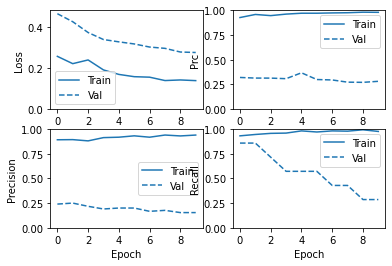

In [100]:
plot_metrics(resampled_history)


In [101]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.32799580693244934
tp :  4.0
fp :  16.0
tn :  105.0
fn :  3.0
accuracy :  0.8515625
precision :  0.20000000298023224
recall :  0.5714285969734192
auc :  0.8742620944976807
prc :  0.36820533871650696

Legitimate Champions Detected (True Negatives):  105
Legitimate Champions Incorrectly Detected (False Positives):  16
Non Champions Missed (False Negatives):  3
Non Champions Detected (True Positives):  4
Total Fraudulent Transactions:  7


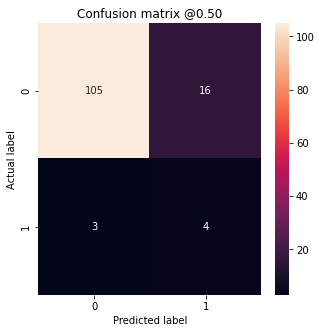

In [102]:
resampled_results = resampled_model.evaluate(X_val, y_val,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_resampled)

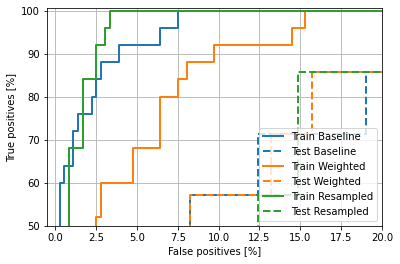

In [103]:

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

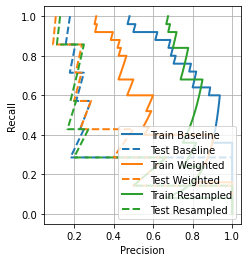

In [104]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Evaluating Performance on Training Set

In [105]:
'''
#Code that will iterate over all years and determine the team with max output from NN

years = np.arange(1990.0,2020.0)

row_list = []

for year in years:

  year_df = test_df[test_df["Year"] == year]
  year_df.reset_index()
  max_idx = pd.to_numeric(year_df["Prediction"]).idxmax()
  row_list.append(dict(test_df.iloc[max_idx]))

max_year_df = pd.DataFrame(row_list, columns = ['Year', 'Team', 'Prediction', 'True'])

'''

'\n#Code that will iterate over all years and determine the team with max output from NN\n\nyears = np.arange(1990.0,2020.0)\n\nrow_list = []\n\nfor year in years:\n\n  year_df = test_df[test_df["Year"] == year]\n  year_df.reset_index()\n  max_idx = pd.to_numeric(year_df["Prediction"]).idxmax()\n  row_list.append(dict(test_df.iloc[max_idx]))\n\nmax_year_df = pd.DataFrame(row_list, columns = [\'Year\', \'Team\', \'Prediction\', \'True\'])\n\n'

## Part 5- Predicting the 2022 Playoffs

### Data Processing

In [106]:
test_data = pd.read_csv('2022_advanced_data.csv')

In [107]:
test_data = test_data[test_data["Playoffs"] == "Y"]

In [108]:
test_data = test_data.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

In [109]:
X_test = test_data.iloc[:, ~ test_data.columns.isin(['Year', 'Champion', 'Team'])]
y_test = test_data.loc[:, test_data.columns == 'Champion'].values
y_test = np.array([0 if val == "N" else 1 for val in y_test])

In [110]:
X_test = np.array(ct.transform(X_test))

In [111]:
X_test = sc.transform(X_test)

### Making Predictions

In [112]:
test_predictions = resampled_model.predict(X_test)

### Organizing the Data

In [113]:
test_arrays = np.column_stack([test_data["Year"], test_data["Team"], test_predictions.flatten()])
test_df = pd.DataFrame(test_arrays, columns = ['Year', 'Team', 'Prediction'])

In [114]:
test_df.sort_values(by=['Prediction'], ascending=False)

,Year,Team,Prediction
13,2022.0,Phoenix Suns,0.97052
6,2022.0,Golden State Warriors,0.698969
8,2022.0,Miami Heat,0.406972
7,2022.0,Memphis Grizzlies,0.269777
1,2022.0,Boston Celtics,0.248316
9,2022.0,Milwaukee Bucks,0.1774
15,2022.0,Utah Jazz,0.104824
4,2022.0,Dallas Mavericks,0.07039
2,2022.0,Brooklyn Nets,0.05381
5,2022.0,Denver Nuggets,0.051135


Based on the model, the teams with output scores > 0.5 are the Suns and Warriors. Based on the magnitude of the scores, we would predict the Suns to be most likely to win the Championship. 